### Pair statistics 

Estimate pair statistics from the GDP data. 

One of the challenges with adopting the code from my paper in https://github.com/dhruvbalwada/SF3_to_KEflux to this work is that the duration of the experiment is really long. Previously we had created `time of experiment` vs `number of drifters` arrays, and then used `pdist` with that. For the GDP data those arrays will be massive and not fit into any memory. Also these arrays will be extremely sparse and filled with NaNs in most places. 

Here we try a similar strategy, but working with shorter intervals of time at once. This allows us to focus on some part of the matrix that is likely to be less sparse.

In [247]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
from scipy.spatial.distance import pdist

In [3]:
ds = xr.open_dataset('data/gdp_subset.nc')

ds

*Note that since we selected a small region of the data, many of the trajectories get chopped. This means that the variable row_size (which was made for original GDP data) doesn't mean much anymore.*
Also the variable ID is not very useful. 

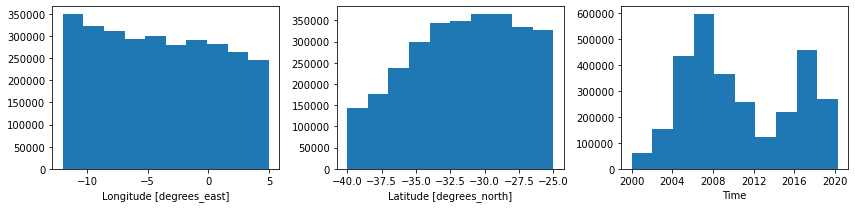

In [9]:
plt.figure(figsize=(12,3))
plt.subplot(131)
ds.lon.plot.hist()

plt.subplot(132)
ds.lat.plot.hist()

plt.subplot(133)
ds.time.plot.hist()

plt.tight_layout()

Start splitting data by year so it becomes easier to access.

In [110]:
def retrieve_year(ds, year) -> xr.Dataset:
    '''Subset the dataset for a region in space and time
    
    Args:
        ds: xarray Dataset
        lon: longitude slice of the subregion
        lat: latitude slice of the subregion
        time: tiem slice of the subregion
    
    Returns: 
        ds_subset: Dataset of the subregion
    '''
    
    # define the mask for the 'obs' dimension
    mask = np.ones(ds.dims['obs'], dtype='bool')

    mask &= (ds.coords['time.year'] == year).values   
    # define the mask for the 'traj' dimension using the ID numbers from the masked observation
    mask_id = np.in1d(ds.ID, np.unique(ds.ids[mask]))
    ds_subset = ds.isel(obs=np.where(mask)[0], traj=np.where(mask_id)[0])

    # Make new row_size using counts
    # this only works if the data is arranged in ascending order of id numbers (which is the case here)
    _, row_size = np.unique(ds_subset.ids, 
                     return_counts=True)
    ds_subset['rowsize'] = xr.DataArray(row_size, dims='traj')
    
    return ds_subset.compute()

In [172]:
%%time
year = 2016
ds_yr = retrieve_year(ds, year)

CPU times: user 323 ms, sys: 2.03 ms, total: 325 ms
Wall time: 321 ms


In [173]:
ds_yr

<xarray.Dataset>
Dimensions:                (traj: 48, obs: 154792)
Coordinates:
    ID                     (traj) int64 101810 109560 ... 63803150 63809060
    lon                    (obs) float32 4.405 4.408 4.41 ... -6.17 -6.18 -6.19
    lat                    (obs) float32 -39.24 -39.23 -39.23 ... -34.51 -34.5
    time                   (obs) datetime64[ns] 2016-10-25T22:00:00 ... 2016-...
    ids                    (obs) int64 101810 101810 ... 63809060 63809060
Dimensions without coordinates: traj, obs
Data variables: (12/54)
    rowsize                (traj) int64 162 47 2463 7717 ... 1379 144 1555 2369
    location_type          (traj) int8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 1 1 1
    WMO                    (traj) int32 1700666 3300657 ... 3300955 3300706
    expno                  (traj) int32 5325 6129 6325 7325 ... 21312 2222 2222
    deploy_date            (traj) datetime64[ns] 2015-11-13 ... 2015-11-09
    deploy_lon             (traj) float32 -44.36 -50.03 5.597 ... -49.47 -43.44
    ...                     ...
    err_sst                (obs) float32 nan nan nan nan ... 0.047 0.045 0.044
    err_sst1               (obs) float32 nan nan nan nan ... 0.016 0.016 0.016
    err_sst2               (obs) float32 nan nan nan nan ... 0.042 0.04 0.04
    flg_sst                (obs) int8 0 0 0 0 0 0 0 0 0 0 ... 5 5 5 5 5 5 5 5 5
    flg_sst1               (obs) int8 0 0 0 0 0 0 0 0 0 0 ... 5 5 5 5 5 5 5 5 5
    flg_sst2               (obs) int8 0 0 0 0 0 0 0 0 0 0 ... 5 5 5 5 5 5 5 5 5
Attributes: (12/15)
    title:             Global Drifter Program hourly drifting buoy collection
    history:           Version 2.00.  Metadata from dirall.dat and deplog.dat
    Conventions:       CF-1.6
    date_created:      2022-06-27T13:53:17.908246
    publisher_name:    GDP Drifter DAC
    publisher_email:   aoml.dftr@noaa.gov
    ...                ...
    metadata_link:     https://www.aoml.noaa.gov/phod/dac/dirall.html
    contributor_name:  NOAA Global Drifter Program
    contributor_role:  Data Acquisition Center
    institution:       NOAA Atlantic Oceanographic and Meteorological Laboratory
    acknowledgement:   Elipot et al. (2022) to be submitted. Elipot et al. (2...
    summary:           Global Drifter Program hourly data

In [174]:
# create the ids of where the trajectories separate out.
traj_idx = np.insert(np.cumsum(ds_yr.rowsize.values), 0, 0)

In [175]:
# check to make sure that everything went smoothly. All lengths elements should be 1. 
num_traj = len(ds_yr.ID)
lengths = np.zeros(num_traj)
for i in range(num_traj):
     lengths[i] = len(np.unique(ds_yr.ids[traj_idx[i]: traj_idx[i+1]]))   
lengths

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [193]:
# Make matlab like structure array.

class structtype():
    pass

trajs = [ structtype() for i in range(num_traj)]

for i in range(num_traj):
    trajs[i].lon = ds_yr.lon[traj_idx[i]:traj_idx[i+1]]
    trajs[i].lat = ds_yr.lat[traj_idx[i]:traj_idx[i+1]]
    trajs[i].u = ds_yr.ve[traj_idx[i]:traj_idx[i+1]]
    trajs[i].v = ds_yr.vn[traj_idx[i]:traj_idx[i+1]]
    trajs[i].time = ds_yr.time[traj_idx[i]:traj_idx[i+1]]

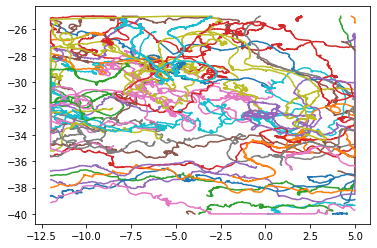

In [194]:
for i in range(num_traj):
    plt.plot(trajs[i].lon, trajs[i].lat)

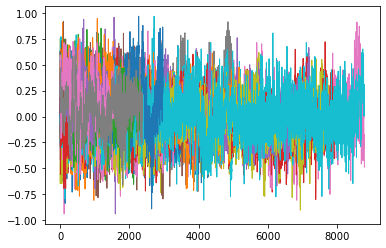

In [197]:
for i in range(num_traj):
    plt.plot(trajs[i].u, linewidth=1)

Text(0.5, 1.0, '48')

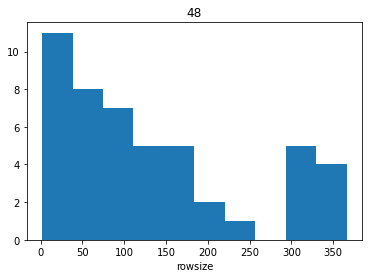

In [178]:
# show how many days of data are present in each traj
(ds_yr.rowsize/24).plot.hist()
plt.title(num_traj)

Create the traj arrays, with size of (number_of_hours_per_year vs number_of_trajs)

In [198]:
if np.mod(year,4)==0:
    hours_per_year = 24*366
else:
    hours_per_year = 24*365
    
lon_array = np.NaN*np.ones((num_traj, hours_per_year))
lat_array = np.NaN*np.ones((num_traj, hours_per_year))
u_array = np.NaN*np.ones((num_traj, hours_per_year))
v_array = np.NaN*np.ones((num_traj, hours_per_year))

In [199]:
start_year = np.datetime64(str(year) + '-01-01')

In [200]:
for i in range(num_traj):
    
    hour_index = ((trajs[i].time - start_year).astype('int')/1e9/3600).values.astype('int')
    # we do this because there can be gaps in data
    
    lon_array[i, hour_index] = trajs[i].lon
    lat_array[i, hour_index] = trajs[i].lat
    u_array[i, hour_index] = trajs[i].u
    v_array[i, hour_index] = trajs[i].v

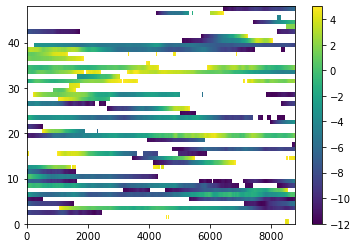

In [201]:
plt.pcolormesh(lon_array)
plt.colorbar()

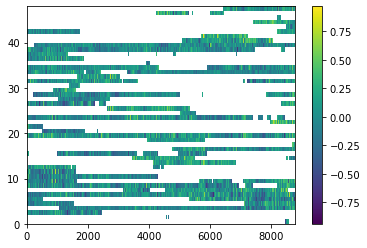

In [202]:
plt.pcolormesh(u_array)
plt.colorbar()

Now that we have traj arrays, we can go about finding pairs.

In [255]:
def dist_rx(XI, XJ):
    rx = (XI[0] - XJ[0])*np.cos(np.deg2rad(0.5*(XI[1] + XJ[1])));
    return rx

def dist_ry(XI, XJ):
    ry = (XI[1] - XJ[1]);
    return ry

def dist_du(UI, UJ):
    du = UI - UJ;
    return du


def dist_geo(XI,XJ):
    # XI or XJ are the coordinates in lon-lat of two different points,
    # where  XI(:,1) is lon and XI(:,2) is the lat. 
    # The function computes the distance between the 2 points.
    #print(XI, XJ)
    X = abs(XI[0] - XJ[0]) *np.cos(np.deg2rad(0.5*(XI[1] + XJ[1]))) *111321;
    Y = abs(XI[1] - XJ[1]) *111321;
    dist = np.sqrt(X**2 + Y**2);
    return dist

In [256]:
pairs_time = [structtype() for i in range(hours_per_year)]

In [267]:
for i in range(hours_per_year):
    
    X = lon_array[:,i]
    Y = lat_array[:,i]
    U = u_array[:,i]
    V = v_array[:,i]
    
    # remove nans
    Y = Y[~np.isnan(X)]
    U = U[~np.isnan(X)]
    V = V[~np.isnan(X)]
    X = X[~np.isnan(X)]
    
    Xvec = np.concatenate((np.expand_dims(X, 1), np.expand_dims(Y, 1)), axis=1)
    
    pairs_time[i].dist = pdist(Xvec, dist_geo)
    
        
    rx = pdist(Xvec, dist_rx);
    ry = pdist(Xvec, dist_ry);
        
    magr = np.sqrt(rx**2 + ry**2);
        
    rx = rx/magr; ry = ry/magr;
        
    dux = pdist(np.expand_dims(U, 1), dist_du);
    duy = pdist(np.expand_dims(V, 1), dist_du);
        
    pairs_time[i].dul = dux*rx + duy*ry;
    pairs_time[i].dut = duy*rx - dux*ry;

(array([10., 31., 27., 27., 25., 25., 20., 12., 11.,  2.]),
 array([  65.17178094,  234.21325611,  403.25473127,  572.29620644,
         741.33768161,  910.37915678, 1079.42063195, 1248.46210712,
        1417.50358228, 1586.54505745, 1755.58653262]),
 <BarContainer object of 10 artists>)

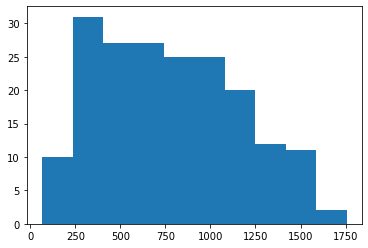

In [266]:
plt.hist(pairs_time[10].dist/1e3)

In [269]:
npairs = np.zeros((hours_per_year,1))

for i in range(hours_per_year):
    npairs[i] = len(pairs_time[i].dul)

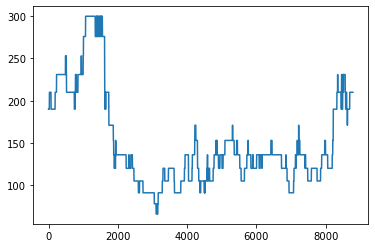

In [270]:
plt.plot(npairs)

In [271]:
npairs.sum()

1326392.0

In [282]:
dul = np.array([])
dut = np.array([])
dist = np.array([])

In [283]:
for i in range(hours_per_year):
    dul = np.append(dul, pairs_time[i].dul)
    dut = np.append(dut, pairs_time[i].dut)
    dist = np.append(dist, pairs_time[i].dist)

Text(0, 0.5, 'Number of pairs')

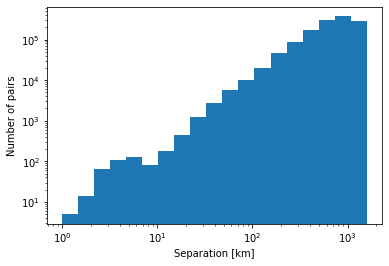

In [294]:
plt.hist(dist/1e3, bins=np.logspace(0, 3.2, 20));
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Separation [km]')
plt.ylabel('Number of pairs')